In [3]:
# --- Cell 1: Import Libraries & Define Constants ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io
import os

# 1. Manual List of Metro Districts (Domain Knowledge / Business Logic)
# Used to bridge the gap in the raw metro dataset which lacks district names.
KNOWN_METRO_DISTRICTS = [
    'العليا', 'الورود', 'الملز', 'البطحاء', 'العقيق',
    'الملقا', 'الصحافة', 'السليمانية', 'المربع', 'الروضة',
    'النسيم الغربي', 'العزيزية', 'قصر الحكم', 'مركز الملك عبدالله المالي',
    'طويق', 'النرجس', 'الياسمين', 'الغدير', 'حطين'
]

# 2. Translation Dictionary (Localization)
# Used to render English labels in visualizations for better reporting.
DISTRICT_TRANSLATION = {
    'العليا': 'Al Olaya', 'الملقا': 'Al Malqa', 'طويق': 'Tuwaiq',
    'العقيق': 'Al Aqiq', 'الصحافة': 'Al Sahafa', 'اليرموك': 'Al Yarmuk',
    'العارض': 'Al Arid', 'النرجس': 'Al Narjis', 'ظهرة لبن': 'Dhahrat Laban',
    'الشفاء': 'Al Shifa', 'السليمانية': 'Al Sulaimaniyah', 'البطحاء': 'Al Batha',
    'الملز': 'Al Malaz', 'النسيم الغربي': 'West Naseem', 'الروضة': 'Al Rawdah',
    'المروج': 'Al Muruj', 'العزيزية': 'Al Aziziyah', 'قرطبة': 'Qurtubah',
    'الياسمين': 'Al Yasmin', 'الخليج': 'Al Khaleej', 'المونسية': 'Al Munsiyah'
}

print("✅ Environment setup completed. Libraries loaded.")

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
# --- Cell 2: Define Data Ingestion Helper ---

def fetch_rcrc_data(dataset_id):
    """
    Fetches CSV data from the RCRC Open Data API.

    Args:
        dataset_id (str): The specific ID of the dataset on the RCRC portal.

    Returns:
        pd.DataFrame: The loaded data as a pandas DataFrame, or None if failed.
    """
    base_url = "https://opendata.rcrc.gov.sa/api/explore/v2.1/catalog/datasets"
    # Using semicolon (;) delimiter as per RCRC standard
    url = f"{base_url}/{dataset_id}/exports/csv?lang=ar&timezone=Asia%2FRiyadh&use_labels=true&delimiter=%3B"

    print(f"Connecting to API: {dataset_id}...")
    try:
        df = pd.read_csv(url, sep=';')
        print(f"Success! Loaded {len(df):,} rows.")
        return df
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

In [ ]:
# --- Cell 3: Data Extraction Phase ---

print("Starting Data Ingestion Pipeline...\n")

# 1. Primary Dataset: Commercial Services
df_services = fetch_rcrc_data("commercial-services-by-category-sub-municipality-and-district-2024")

# 2. Secondary Dataset: Metro Stations (For Context)
df_metro = fetch_rcrc_data("metro-stations-in-riyadh-by-metro-line-and-station-type-2024")

# 3. Tertiary Dataset: Housing Data (For Context)
df_housing = fetch_rcrc_data("residential-in-land-use-by-housing-type-and-municipality-2019")

# Validate Primary Data
if df_services is not None:
    print("\nPreview of Raw Services Data:")
    print(df_services.head(3))

Starting Data Ingestion Pipeline...



NameError: name 'fetch_rcrc_data' is not defined

In [4]:
# --- Cell 4: Data Transformation Layer ---

if df_services is not None:
    print("Transforming and enriching data...")

    # 1. Standardization: Rename columns to English snake_case
    df_clean = df_services.rename(columns={
        'البلدية الفرعية': 'sub_municipality',
        'اسم الحي': 'district_name',
        'التصنيف': 'category'
    })

    # 2. Aggregation: Calculate service density per district
    # Group by District -> Count Rows -> Reset Index
    final_df = df_clean.groupby('district_name').size().reset_index(name='services_count')

    # 3. Feature Engineering: Metro Connectivity
    # Tag districts based on the predefined 'KNOWN_METRO_DISTRICTS' list
    final_df['has_metro'] = final_df['district_name'].isin(KNOWN_METRO_DISTRICTS)

    # 4. Localization: Map Arabic names to English
    final_df['district_name_en'] = final_df['district_name'].apply(
        lambda x: DISTRICT_TRANSLATION.get(x, f"District ({x})")
    )

    # 5. Cross-Reference Metrics (Context from other datasets)
    metro_stations_count = len(df_metro) if df_metro is not None else 0
    housing_records_count = len(df_housing) if df_housing is not None else 0

    print("Transformation complete. 'final_df' is ready for analysis.")
    print(f"   - Total Districts Processed: {len(final_df)}")
else:
    print("Transformation skipped: Primary dataset is missing.")

NameError: name 'df_services' is not defined

/tmp/ipython-input-3836965603.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=viz_df, x='Metro_Status', y='services_count', estimator='mean', errorbar=None, palette=['gray', '#2ecc71'], ax=ax2)
/tmp/ipython-input-3836965603.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10, x='services_count', y='district_name_en', palette='viridis', ax=ax4)


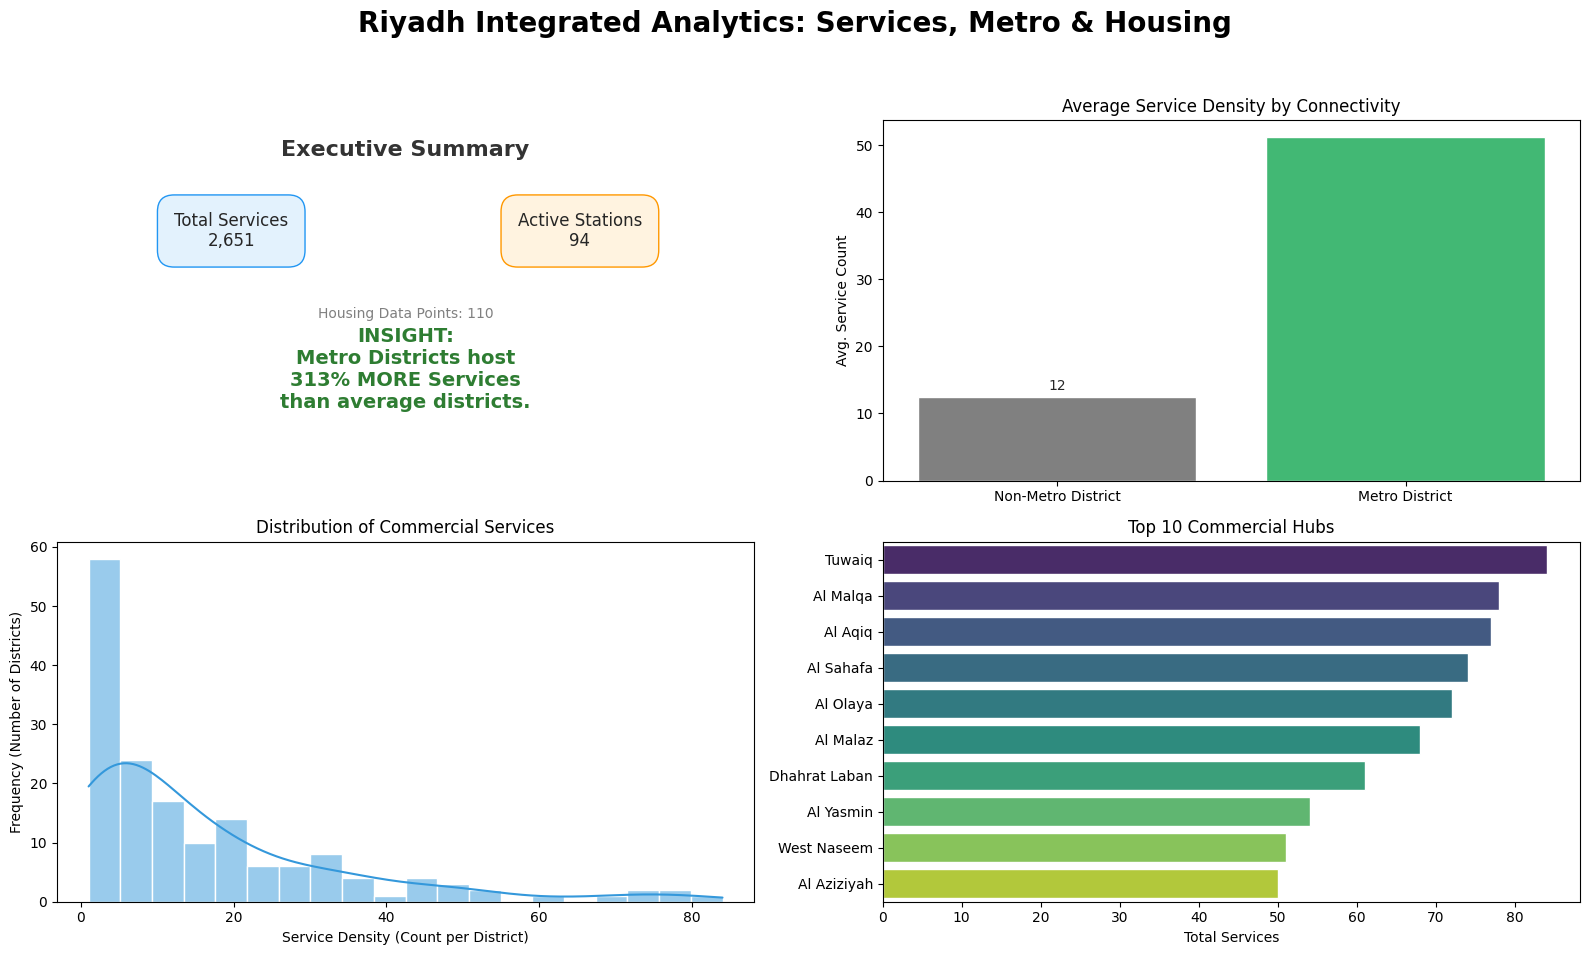

📊 Dashboard generated successfully.


In [ ]:
# --- Cell 5: Generate Analytics Dashboard ---

if 'final_df' in locals():
    # Prepare visualization dataframe
    viz_df = final_df.copy()
    viz_df['Metro_Status'] = viz_df['has_metro'].map({True: 'Metro District', False: 'Non-Metro District'})

    # Calculate KPIs
    total_services = viz_df['services_count'].sum()
    avg_metro = viz_df[viz_df['has_metro']]['services_count'].mean()
    avg_non_metro = viz_df[~viz_df['has_metro']]['services_count'].mean()

    # Calculate Percentage Difference
    diff_pct = ((avg_metro - avg_non_metro) / avg_non_metro) * 100

    # Initialize Canvas
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Riyadh Integrated Analytics: Services, Metro & Housing', fontsize=20, weight='bold')
    sns.set_style("whitegrid")

    # --- Plot 1: Executive Summary Scorecard ---
    ax1 = axes[0, 0]
    ax1.axis('off')
    ax1.text(0.5, 0.9, 'Executive Summary', ha='center', fontsize=16, weight='bold', color='#333')

    # KPI Boxes
    ax1.text(0.25, 0.65, f'Total Services\n{int(total_services):,}', ha='center', fontsize=12,
             bbox=dict(facecolor='#e3f2fd', edgecolor='#2196f3', boxstyle='round,pad=1'))

    ax1.text(0.75, 0.65, f'Active Stations\n{metro_stations_count}', ha='center', fontsize=12,
             bbox=dict(facecolor='#fff3e0', edgecolor='#ff9800', boxstyle='round,pad=1'))

    ax1.text(0.5, 0.45, f'Housing Data Points: {housing_records_count:,}', ha='center', fontsize=10, color='gray')

    # Key Insight Text
    ax1.text(0.5, 0.2, f'INSIGHT:\nMetro Districts host\n{diff_pct:.0f}% MORE Services\nthan average districts.',
             ha='center', fontsize=14, weight='bold', color='#2e7d32')

    # --- Plot 2: Average Density Comparison ---
    ax2 = axes[0, 1]
    sns.barplot(data=viz_df, x='Metro_Status', y='services_count', estimator='mean', errorbar=None, palette=['gray', '#2ecc71'], ax=ax2)
    ax2.set_title('Average Service Density by Connectivity', fontsize=12)
    ax2.set_ylabel('Avg. Service Count')
    ax2.set_xlabel('')
    ax2.bar_label(ax2.containers[0], fmt='%.0f', padding=3)

    # --- Plot 3: Distribution Histogram ---
    ax3 = axes[1, 0]
    sns.histplot(data=viz_df, x='services_count', bins=20, color='#3498db', kde=True, ax=ax3)
    ax3.set_title('Distribution of Commercial Services', fontsize=12)
    ax3.set_xlabel('Service Density (Count per District)')
    ax3.set_ylabel('Frequency (Number of Districts)')

    # --- Plot 4: Top 10 Districts ---
    ax4 = axes[1, 1]
    top_10 = viz_df.sort_values(by='services_count', ascending=False).head(10)
    sns.barplot(data=top_10, x='services_count', y='district_name_en', palette='viridis', ax=ax4)
    ax4.set_title('Top 10 Commercial Hubs', fontsize=12)
    ax4.set_xlabel('Total Services')
    ax4.set_ylabel('')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    print("Dashboard generated successfully.")

In [ ]:
# --- Cell 6: Data Loading & Export ---
from google.colab import files

filename = "riyadh_integrated_analysis.csv"

if 'final_df' in locals():
    print(f"Saving processed dataset to {filename}...")
    final_df.to_csv(filename, index=False, encoding='utf-8-sig')

    print("⬇Triggering download...")
    files.download(filename)
else:
    print("No data to save.")

💾 Saving processed dataset to riyadh_integrated_analysis.csv...
⬇️ Triggering download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>